In [2]:
import os
import ipynb
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import statistics
from scipy.stats import loguniform

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils._testing import ignore_warnings 
from sklearn.metrics import classification_report

from ipynb.fs.full.preprocessing import preprocessing #import preprocessing class from preprocessing.ipynb
from ipynb.fs.full.accuracy_plots import cumulative_accuracy_plot #import fx from accuracy_plots.ipynb
from ipynb.fs.full.accuracy_plots import accuracy_by_nfeatures #import fx from accuracy_plots.ipynb

In [1]:
#Restore saved dataframes from 00_EDA.ipynb
%store -r dwt_8 wang_8 jones_8
dwt_8 = dwt_8
wang_8 = wang_8
jones_8 = jones_8

%store -r dwt_topten_8 wang_topten_8 jones_topten_8
dwt_topten_8 = dwt_topten_8
wang_topten_8 = wang_topten_8
jones_topten_8 = jones_topten_8

%store -r dwt_4 wang_4 jones_4
dwt_4 = dwt_4
wang_4 = wang_4
jones_4 = jones_4

%store -r dwt_topten_4 wang_topten_4 jones_topten_4
dwt_topten_4 = dwt_topten_4
wang_topten_4 = wang_topten_4
jones_topten_4 = jones_topten_4


In [4]:
def knn(df, n_iter=1000):

    df = df

    subset_0 = df[df['state'] == 0]
    subset_1 = df[df['state'] == 1]

    subset_1 = subset_1.sample(n=91) #randomly sample cases to match number of controls
    df = pd.concat([subset_0, subset_1])
                     
    x = df.loc[:, df.columns != 'state'] #features
    y = df.loc[:, df.columns == 'state'] #supervisor

    eval_metrics = { #empty dictionary to store classification report
        '0_precision': [],
        '0_recall': [],
        '0_f1-score': [],
        '0_support': [],

        '1_precision': [],
        '1_recall': [],
        '1_f1-score': [],
        '1_support': [],
        
        'accuracy': [],
        'accuracy_train': [],
    }

    for i in range(n_iter): 

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.67)

        scaler = StandardScaler()    
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        knn_model = KNeighborsClassifier()
        knn_model.fit(x_train, y_train.values.ravel())
        
        y_pred = knn_model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        y_pred_train = knn_model.predict(x_train)
        report_train = classification_report(y_train, y_pred_train, output_dict=True)

        eval_metrics['0_precision'].append(report['0']['precision']) #store classification_report values in dictionary
        eval_metrics['0_recall'].append(report['0']['recall'])
        eval_metrics['0_f1-score'].append(report['0']['f1-score'])
        eval_metrics['0_support'].append(report['0']['support'])

        eval_metrics['1_precision'].append(report['1']['precision'])
        eval_metrics['1_recall'].append(report['1']['recall'])
        eval_metrics['1_f1-score'].append(report['1']['f1-score'])
        eval_metrics['1_support'].append(report['1']['support'])

        eval_metrics['accuracy'].append(report['accuracy'])
        eval_metrics['accuracy_train'].append(report_train['accuracy'])

    eval_metrics_df = pd.DataFrame.from_dict(eval_metrics) #convert dictionary to dataframe

    return eval_metrics_df

In [5]:
acc_df_dwt = knn(dwt10, n_iter=1000)
acc_df_wang = knn(wang10, n_iter=1000)
acc_df_jones = knn(jones10, n_iter=1000)

print('DWT Method Accuracy ', round(acc_df_dwt['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_df_wang['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_df_jones['accuracy'].mean(), 4))

DWT Method Accuracy  0.9346
Wang Method Accuracy  0.9614
Jones Method Accuracy  0.7966


In [6]:
acc_dwt_4 = knn(dwt_topten_4, n_iter=1000)
acc_wang_4 = knn(wang_topten_4, n_iter=1000)
acc_jones_4 = knn(jones_topten_4, n_iter=1000)

print('DWT Method Accuracy ', round(acc_dwt_4['accuracy'].mean(), 4))
print('Wang Method Accuracy ', round(acc_wang_4['accuracy'].mean(), 4))
print('Jones Method Accuracy ', round(acc_jones_4['accuracy'].mean(), 4))

DWT Method Accuracy  0.8307
Wang Method Accuracy  0.7998
Jones Method Accuracy  0.7895


### Cumulative Accuracy Plot Function

In [14]:
### Cumulative Accuracy Plot Function
knn_feat_accuracy_dwt = accuracy_by_nfeatures(class_instance=prep_dwt, file_name='DWT', classifier=knn, n_features=29, n_iter=500)
knn_feat_accuracy_wang = accuracy_by_nfeatures(class_instance=prep_wang, file_name='Wang', classifier=knn, n_features=29, n_iter=500)
knn_feat_accuracy_jones = accuracy_by_nfeatures(class_instance=prep_jones, file_name='Jones', classifier=knn, n_features=29, n_iter=500)

In [15]:
knn_feat_accuracy_dwt = knn_feat_accuracy_dwt.rename(
                               columns = lambda col: f"{col}_dwt"
                               if col not in ('n_features', 'file_name') else col)


knn_feat_accuracy_wang = knn_feat_accuracy_wang.rename(
                               columns = lambda col: f"{col}_wang"
                               if col not in ('n_features', 'file_name') else col)


knn_feat_accuracy_jones = knn_feat_accuracy_jones.rename(
                               columns = lambda col: f"{col}_jones"
                               if col not in ('n_features', 'file_name') else col) 

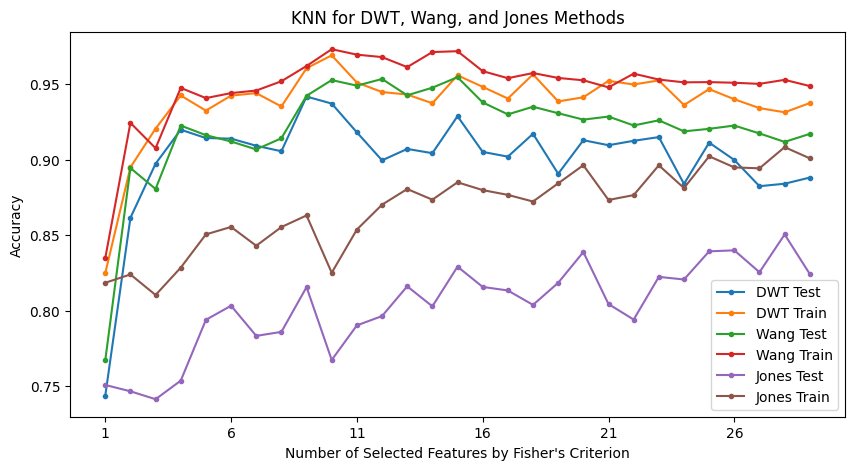

In [18]:
#merge three dataframes on n_features
merged_feat_accuracy_knn = knn_feat_accuracy_dwt.merge(knn_feat_accuracy_wang, how='right', on='n_features').merge(knn_feat_accuracy_jones, how='right', on='n_features')

merged_feat_accuracy_knn.head()
merged_feat_accuracy_knn.plot(
            x='n_features', 
            y=['mean_dwt', 'mean_train_dwt', 'mean_wang', 'mean_train_wang', 'mean_jones', 'mean_train_jones'],
            marker='.', 
            title='KNN for DWT, Wang, and Jones Methods',
            xlabel="Number of Selected Features by Fisher's Criterion", 
            ylabel='Accuracy', 
            figsize=(10,5))

plt.legend(['DWT Test', 'DWT Train', 'Wang Test', 'Wang Train', 'Jones Test', 'Jones Train'], loc='lower right')